**Helpful Documentation**

*Documentation for stock library:
https://readthedocs.org/projects/pandas-datareader/downloads/pdf/latest/

*Documentation for dataframes below:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html

*Documentation for plotting pretty graphs below:
https://matplotlib.org/3.2.1/tutorials/introductory/sample_plots.html

In [ ]:
# Install required Libraries
!pip install pandas_datareader

In [ ]:
# Import Libraries
from pandas_datareader import data
from datetime import date

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
import tensorflow as tf

# Get Current Date
today = date.today()
currentDate = today.strftime("%Y/%m/%d")

## Set Info
start_date = '2015-06-10'
end_date = currentDate
stockName = 'AMZN'

# Get the data
stockData = data.get_data_yahoo(stockName, start_date, end_date)


Test accessing columns and all data


In [260]:
# Overview everything
stockData.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-06-10,254.000000,248.500000,251.899994,250.699997,3454500,250.699997
2015-06-11,254.369995,250.429993,253.259995,251.410004,2044100,251.410004
2015-06-12,253.460007,250.210007,250.210007,250.690002,1422300,250.690002
2015-06-15,251.279999,246.009995,249.699997,250.380005,2186200,250.380005
2015-06-16,253.440002,249.100006,250.130005,253.119995,1984700,253.119995


Plot raw results

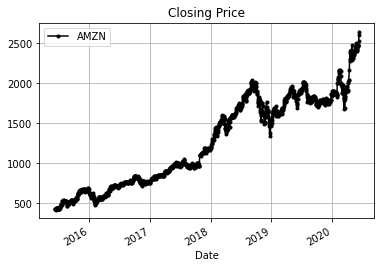

In [301]:
# Make pretty plot
stockData["Close"].plot(label=stockName, color='black', marker='.', title="Closing Price")
plt.legend()
plt.grid()
currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

Implement regression using Recurrent Neural Network

In [302]:
# Add the dates as columns
stockData['Year'] = stockData.index.year
stockData['Month'] = stockData.index.month
stockData['Day'] = stockData.index.day #print(stockData)

# Shift dataframe by amount to predict 
days = 1
stepsToShift = days * 2

# Create separate dataframe to predict
columns = ['High','Low','Open','Close','Volume']
stockDataToPredict = stockData[columns].shift(-stepsToShift)

# Set up data
dataIn = stockData.values[0:-stepsToShift] #print(x_data.shape)
dataOut = stockDataToPredict.values[:-stepsToShift]

# allocate space for training and test data
numData = len(dataIn)
trainPercentage = 0.7
numTrain = int(trainPercentage * numData)
numTest = numData-numTrain

# split into training and test data
xTrain = stockData[0:numTrain]
yTrain = stockDataToPredict[0:numTrain]

xTest = stockData[numTrain:]
yTest = stockDataToPredict[numTrain:]

print(yTest)

                   High          Low         Open        Close     Volume
Date                                                                     
2018-12-06  1657.989990  1590.869995  1623.839966  1641.030029  7494800.0
2018-12-07  1679.469971  1619.599976  1678.000000  1643.239990  6244700.0
2018-12-10  1704.989990  1660.270020  1669.000000  1663.540039  6598000.0
2018-12-11  1692.119995  1641.500000  1680.000000  1658.380005  5271300.0
2018-12-12  1642.569946  1585.000000  1638.000000  1591.910034  6367200.0
...                 ...          ...          ...          ...        ...
2020-06-04  2530.000000  2487.340088  2500.199951  2524.060059  3970700.0
2020-06-05  2626.429932  2525.000000  2529.439941  2600.860107  5166000.0
2020-06-08  2690.000000  2630.354980  2645.000000  2646.189941  3321025.0
2020-06-09          NaN          NaN          NaN          NaN        NaN
2020-06-10          NaN          NaN          NaN          NaN        NaN

[380 rows x 5 columns]


In [303]:
# Check the max/min values
print("Min:", np.min(xTrain))
print("Max:", np.max(yTrain))

# Normalize values between 0-1
scalerX = MinMaxScaler()
xTrainNorm = scalerX.fit_transform(xTrain)
xTestNorm = scalerX.transform(xTest)

scalerY = MinMaxScaler()
yTrainNorm = scalerY.fit_transform(yTrain)
yTestNorm = scalerY.transform(yTest)


Min: High         4.279700e+02
Low          4.226400e+02
Open         4.241500e+02
Close        4.236700e+02
Volume       1.091200e+06
Adj Close    4.236700e+02
Year         2.015000e+03
Month        1.000000e+00
Day          1.000000e+00
dtype: float64
Max: High      2.050500e+03
Low       2.013000e+03
Open      2.038110e+03
Close     2.039510e+03
Volume    2.190940e+07
dtype: float64


In [304]:
# Recurrent Neural Network GRU
model = Sequential()

numIn = stockData.shape[1]
numOut = stockDataToPredict.shape[1]

# add gated recurrent unit
model.add(GRU(units=512, return_sequences=True, input_shape=(None,numIn,)))
model.add(Dense(numOut, activation='sigmoid'))

# set learning rate and compile model
optimizerChoice = RMSprop(lr=1e-3) # try RMS

model.compile(loss='mean_squared_error', optimizer=optimizerChoice)
model.summary()


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 (None, None, 512)         803328    
_________________________________________________________________
dense_40 (Dense)             (None, None, 5)           2565      
Total params: 805,893
Trainable params: 805,893
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Callbacks for early stopping and reducing learning rate and checkpoint
path_checkpoint = '23_checkpoint.keras'

# checkpoints
callbackCheckpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

# early stopping
callbackEarlyStopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

# reducing learning rate
callbackLearningRate = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
# pass when training
callbacks = [callbackCheckpoint, callbackEarlyStopping, callbackLearningRate]

In [ ]:
  """
  Generator function for creating random batches of training-data.
  """
def batch_generator(batchSize, sequenceLength):

    while True:
        # Create array for the batch of input and outputs.
        xShape = (batchSize, sequenceLength, numIn)
        xBatch = np.zeros(shape=xShape, dtype=np.float16)
        yShape = (batchSize, sequenceLength, numOut)
        yBatch = np.zeros(shape=yShape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batchSize):
            # Get a random start-index.
            idx = np.random.randint(numTrain - sequenceLength)
            
            # Copy the sequences of data starting at this index.
            xBatch[i] = xTrainNorm[idx : idx+sequenceLength]
            yBatch[i] = yTrainNorm[idx : idx+sequenceLength]
        
        yield (xBatch, yBatch)


In [307]:
# Training the model
xBatches = batch_generator(batchSize=256,sequenceLength=100)

validation_data = (np.expand_dims(xTestNorm, axis=0),
                   np.expand_dims(yTestNorm, axis=0))

model.fit(x=xBatches, epochs=20, steps_per_epoch=100, validation_data=validation_data, callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0129
Epoch 00001: val_loss did not improve from inf

Epoch 00001: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 16s 155ms/step - loss: 0.0129 - val_loss: nan - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0032
Epoch 00002: val_loss did not improve from inf

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 15s 151ms/step - loss: 0.0032 - val_loss: nan - lr: 1.0000e-04
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0027
Epoch 00003: val_loss did not improve from inf
100/100 [==============================] - 15s 152ms/step - loss: 0.0027 - val_loss: nan - lr: 1.0000e-04
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0025
Epoch 00004: val_loss did not improve from inf
100/100 [==============================] -

**Testing with Test Data**

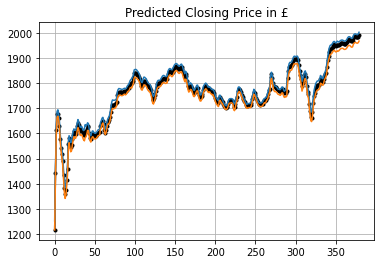

In [308]:
# Use the model to predict on Test Data.
inputToPredict = np.expand_dims(xTestNorm, axis=0)
predictedNormVal = model.predict(inputToPredict)

# scale back from normalization
predictedValuesY = scalerY.inverse_transform(predictedNormVal[0])

#plt.plot(predictedValues)
#yTest.plot()

# separate result for plotting
highPred = predictedValuesY[:,0]
lowPred = predictedValuesY[:,1]
openPred = predictedValuesY[:,2]
closePred = predictedValuesY[:,3]
volumPred = predictedValuesY[:,4]

# Plot Predicted 
plt.plot(closePred, color='black', marker='.')
plt.plot(highPred)
plt.plot(lowPred)

plt.title('Predicted Closing Price in £')
plt.grid()
currentFig = plt.gcf()
currentFig.set_facecolor('white')


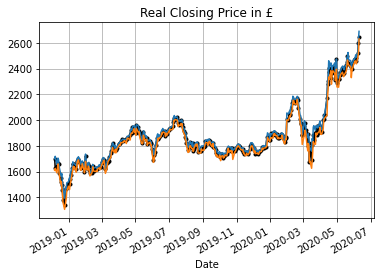

In [309]:
# Plot Real
xTest['Close'].plot(label=stockName, color='black', marker='.', title="Real Closing Price in £")
xTest['High'].plot()
xTest['Low'].plot()

plt.grid()
currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()

**Testing with Training Data**

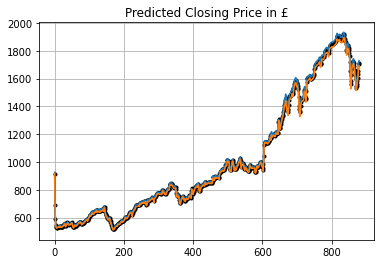

In [310]:
# Use the model to predict on Training Data.
inputToPredict = np.expand_dims(xTrainNorm, axis=0)
predictedNormVal = model.predict(inputToPredict)

# scale back from normalization
predictedValuesY = scalerY.inverse_transform(predictedNormVal[0])

#plt.plot(predictedValues)
#yTest.plot()

# separate result for plotting
highPred = predictedValuesY[:,0]
lowPred = predictedValuesY[:,1]
openPred = predictedValuesY[:,2]
closePred = predictedValuesY[:,3]
volumPred = predictedValuesY[:,4]

# Plot Predicted 
plt.plot(closePred, color='black', marker='.')
plt.plot(highPred)
plt.plot(lowPred)

plt.title('Predicted Closing Price in £')
plt.grid()
currentFig = plt.gcf()
currentFig.set_facecolor('white')



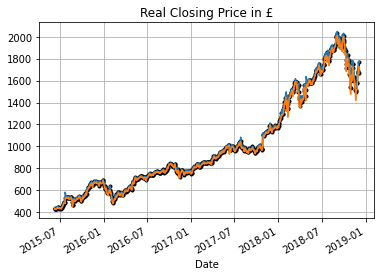

In [311]:
xTrain['Close'].plot(label=stockName, color='black', marker='.', title="Real Closing Price in £")
xTrain['High'].plot()
xTrain['Low'].plot()

plt.grid()
currentFig = plt.gcf()
currentFig.set_facecolor('white')
plt.show()